In [1]:
import arviz as az
import numpy as np
import xarray as xr
import pandas as pd
import pymc as pm
from pymc.math import dot, invlogit
import seaborn as sns

# 15. GLM Examples*

## Arrhythmia

A logistic regression example, adapted from [Unit 7: arrhythmia.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit7/arrhythmia.odc).

### Data descriptions

I mirrored the data [here](https://raw.githubusercontent.com/areding/6420-pymc/main/data/arrhythmia.csv).

| Variable ID | Name | Description |
|-------------|------|-------------|
| Y           | Fibrillation | Outcome variable: presence of fibrillation.|
| X1          | Age | Age of the patient. |
| X2          | Aortic Cross Clamp Time | Duration of time the aortic valve is clamped during surgery. |
| X3          | Cardiopulmonary Bypass Time | Bypass of the heart and lungs. Involves diverting blood through a heart-lung machine, which performs the functions of the heart and lungs. |
| X4          | ICU Time | Time spent in the Intensive Care Unit. |
| X5          | Avg Heart Rate | Average heart rate of the patient. |
| X6          | Left Ventricle Ejection Fraction | Measure of how well the left ventricle pumps blood out to the body. |
| X7          | Hypertension | Binary: Presence (1) or absence (0) of high blood pressure. |
| X8          | Gender | Binary: 1 for female; 0 for male. |
| X9          | Diabetes | Binary: Presence (1) or absence (0) of diabetes. |
| X10         | Previous MI | Binary: Presence (1) or absence (0) of a previous myocardial infarction (heart attack). |

### Background

Patients who undergo Coronary Artery Bypass Graft Surgery (CABG) have an approximate 19–40% chance of developing atrial fibrillation (AF). AF can lead to the formation of blood clots, resulting in increased in-hospital mortality, strokes, and longer hospital stays. While drugs can prevent this condition, they are expensive and can be dangerous if not warranted. Ideally, identifying several risk factors that indicate an increased risk of developing AF could save lives and money by showing which patients need pharmacological intervention. Researchers have begun collecting data such as demographics, heart rate, cholesterol, and operation time from CABG patients during their hospital stays. They have also recorded which patients developed AF. The goal now is to identify the data points that signal a high risk of AF. In the past, factors such as age, hypertension, and body surface area (BSA) have been useful indicators, although they have not provided a satisfactory solution on their own.

Fibrillation occurs when the heart muscle begins a quivering motion instead of maintaining a normal, healthy pumping rhythm. Fibrillation can affect either the atrium (atrial fibrillation) or the ventricle (ventricular fibrillation); the latter is imminently life-threatening.

Atrial fibrillation involves quivering, chaotic motion in the upper chambers of the heart, known as the atria. It is often linked to serious underlying medical conditions and should be evaluated by a physician. Although it is not typically a medical emergency, it still requires medical attention.

Ventricular fibrillation occurs in the ventricles (lower chambers) of the heart and is always a medical emergency. If left untreated, ventricular fibrillation (VF, or V-fib) can lead to death within minutes. When the heart enters V-fib, effective blood pumping ceases. V-fib is considered a form of cardiac arrest, and an individual experiencing it will not survive unless immediate cardiopulmonary resuscitation (CPR) and defibrillation are administered.

### Model

This is a logistic regression model. We consider each patient's outcome a single Bernoulli event.

$$
\begin{align*}
y_i | \boldsymbol{\beta}, \mathbf{x}_i &\sim \text{Bernoulli}(p_i) \\
g(p_i) &= \beta_0 + \sum_{j=1}^p \beta_j x_{ij} \\
\beta_0 &\sim \mathcal{N}(0, \sigma_0^2) && \text{Intercept variance may be higher than coefficient variance.}\\
\beta_j &\sim \mathcal{N}(0, \sigma^2), \quad j = 1, 2, \ldots, k
\end{align*}
$$

where $k$ is the number of predictors and $g(\cdot)$ is the logit function: $\text{logit}(p) = \ln\left(\frac{p}{1-p}\right)$, and its inverse $g^{-1}(\cdot)$ is the logistic function: $\text{logistic}(x) = \frac{1}{1 + e^{-x}}$.

If your data is in an aggregated format, you should consider going with a Binomial likelihood. The model can be equivalently stated this way:

$$
\begin{align*}
y_i | \boldsymbol{\beta}, \mathbf{x}_i &\sim \text{Binomial}(n_i, p_i) \\
g(p_i) &= \beta_0 + \sum_{j=1}^p \beta_j x_{ij} \\
\beta_0 &\sim \mathcal{N}(0, \sigma_0^2) && \text{Intercept variance may be higher than coefficient variance.}\\
\beta_j &\sim \mathcal{N}(0, \sigma^2), \quad j = 1, 2 \ldots, k
\end{align*}
$$

In [2]:
data_df = pd.read_csv("../data/arrhythmia.csv")
data_df.info()
X = data_df.iloc[:, 1:]
y = data_df["Fibrillation"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Fibrillation                   81 non-null     float64
 1   Age                            81 non-null     float64
 2   AorticCrossClampTime           81 non-null     float64
 3   CardiopulmonaryBypassTime      81 non-null     float64
 4   ICUTime                        81 non-null     float64
 5   AvgHeartRate                   81 non-null     float64
 6   LeftVentricleEjectionFraction  81 non-null     float64
 7   Hypertension                   81 non-null     float64
 8   Gender                         81 non-null     float64
 9   Diabetes                       81 non-null     float64
 10  PreviousMI                     81 non-null     float64
dtypes: float64(11)
memory usage: 7.1 KB


In [3]:
data_df.describe()

,Fibrillation,Age,AorticCrossClampTime,CardiopulmonaryBypassTime,ICUTime,AvgHeartRate,LeftVentricleEjectionFraction,Hypertension,Gender,Diabetes,PreviousMI
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,0.345679,66.654321,81.753086,131.123457,16.148716,85.683951,56.401235,0.666667,0.308642,0.419753,0.469136
std,0.478552,10.429718,30.322241,56.196170,3.672736,11.847557,13.634153,0.474342,0.464811,0.496593,0.502156
min,0.000000,44.000000,0.000000,0.000000,2.000000,50.000000,18.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,61.000000,67.000000,109.000000,13.500000,77.200000,50.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,69.000000,82.000000,128.000000,16.000000,86.700000,59.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,73.000000,98.000000,148.000000,19.000000,94.800000,65.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,88.000000,193.000000,487.000000,23.000000,111.800000,82.000000,1.000000,1.000000,1.000000,1.000000


Our predictors have very different scales. With non-informative priors as the professor uses in the BUGS model, the coefficients should have no trouble fitting the data. However, since PyMC uses a different sampling algorithm it seems to be having trouble with the shape of the posterior. Actually, this used to work fine in PyMC (as of version 5.1.2, at least), but students in Fall 2023 discovered that PyMC could no longer sample this model without divergences (using version 5.9.0 or above).

In [4]:
with pm.Model() as m:
    X_data = pm.Data("X_data", X, mutable=True)
    y_data = pm.Data("y_data", y, mutable=False)

    alpha = pm.Normal("alpha", mu=0, sigma=10)
    betas = pm.Normal("beta", mu=0, sigma=5, shape=X.shape[1])

    p = invlogit(alpha + dot(X_data, betas))

    pm.Bernoulli("y", p=p, observed=y_data)

    trace = pm.sample(5000)

/Users/aaron/miniforge3/envs/pymc_macos15/lib/python3.12/site-packages/pymc/data.py:440: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.
There were 20000 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [5]:
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.341,0.414,-0.729,0.299,0.207,0.158,4.0,4.0,6.09
beta[0],0.165,0.629,-0.779,0.853,0.314,0.241,4.0,13.0,5.45
beta[1],-0.213,0.464,-0.798,0.303,0.232,0.178,4.0,4.0,12.44
beta[2],0.200,0.405,-0.176,0.868,0.202,0.155,4.0,4.0,18.68
beta[3],-0.296,0.591,-0.978,0.619,0.296,0.226,4.0,4.0,6.16
beta[4],0.047,0.303,-0.448,0.465,0.151,0.116,4.0,11.0,6.19
beta[5],-0.095,0.371,-0.498,0.476,0.185,0.142,4.0,4.0,18.68
beta[6],-0.063,0.428,-0.506,0.504,0.214,0.164,4.0,4.0,16.05
beta[7],0.187,0.386,-0.322,0.684,0.193,0.148,4.0,4.0,14.14
beta[8],-0.047,0.723,-0.792,0.855,0.361,0.277,4.0,4.0,15.53


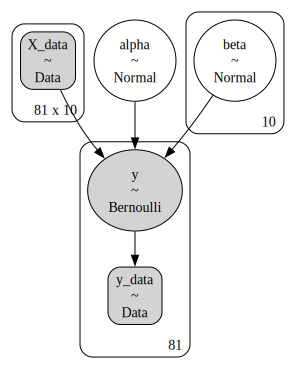

In [6]:
m.to_graphviz()

With that many divergences, there's no way the model fit correctly, and that's borne out in the summary statistics with each r_hat being well above 1.01. So we may need to standardize our data. Andrew Gelman {cite:t}`gelmanstandardization` [suggests](https://stat.columbia.edu/~gelman/research/published/standardizing7.pdf) standardizing by two standard deviations.

In [7]:
def standardize(X_df: pd.DataFrame) -> pd.DataFrame:
    """
    Standardize input variables by 2 std dev.

    See https://stat.columbia.edu/~gelman/research/published/standardizing7.pdf.
    """
    # find and store means and std, then standardize
    means = X_df.mean(axis=0)
    stdevs = X_df.std(axis=0)
    X_standardized = (X_df - means) / (2 * stdevs)

    return X_standardized

In [8]:
X_std = standardize(data_df.iloc[:, 1:])

In [9]:
with m:
    pm.set_data({"X_data": X_std})
    trace_std = pm.sample(5000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


Looks like the model fit just fine this time.

In [10]:
az.summary(trace_std, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.208,0.358,-1.941,-0.535,0.003,0.002,14434.0,14377.0,1.0
beta[0],3.705,0.970,1.889,5.626,0.008,0.006,14855.0,13548.0,1.0
beta[1],1.599,1.382,-1.001,4.447,0.013,0.010,11768.0,12302.0,1.0
beta[2],-2.139,1.592,-5.215,0.918,0.015,0.011,11791.0,11846.0,1.0
beta[3],-1.066,0.684,-2.404,0.299,0.005,0.004,18636.0,14453.0,1.0
beta[4],0.104,0.721,-1.306,1.532,0.005,0.005,18776.0,15498.0,1.0
beta[5],0.638,0.744,-0.855,2.044,0.006,0.004,16116.0,14988.0,1.0
beta[6],-0.596,0.626,-1.816,0.612,0.005,0.004,18015.0,15016.0,1.0
beta[7],-0.279,0.626,-1.468,0.984,0.004,0.004,21042.0,15519.0,1.0
beta[8],1.235,0.662,-0.057,2.544,0.005,0.004,18430.0,15550.0,1.0


## Ants

An example of Poisson regression, adapted from [Unit 7: ants.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit7/ants.odc).


### Data description
Data can be found [here](https://raw.githubusercontent.com/areding/6420-pymc/main/data/ants.csv).

The data discussed in Gotelli and Ellison (2002) provide the ant species richness (number of ant species) found in 64-square-meter sampling grids in 22 forests (coded as 1) and 22 bogs (coded as 2) surrounding the forests in  Connecticut, Massachusetts, and Vermont. The sites span 3 degrees of latitude in New England. There are 44 observations on four variables (columns in data set): 

- Ants: number of species, 
- Habitat: forests (1) and bogs (2), 
- Elevation: in meters above sea level.

(a) Using Poisson regression, model the number of ant species (Ants) with covariates Habitat and Elevation.  
(b) For a sampling grid unit located in a forest at the elevation of 100 m how many species the model from (a) predicts? For the model coefficients and the prediction report 95% credible  sets.

### Poisson regression model

$$
\begin{align*}
y_i | \boldsymbol{\theta}, \mathbf{X} &\sim \text{Poisson}(\lambda_i) \\
\lambda_i &= g^{-1}(\beta_0 + \sum_{j=1}^p \beta_j x_{ij}) \\
\beta_0 &\sim \mathcal{N}(0, \sigma_0^2) && \text{Intercept variance may be higher than coefficient variance.}\\
\beta_j &\sim \mathcal{N}(0, \sigma^2) \\
\end{align*}
$$

For Poisson regression our link function $g(\cdot)$ is the natural logarithm and its inverse $g^{-1}(\cdot)$ is the exponential function.

In [11]:
data = pd.read_csv("../data/ants.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ants       44 non-null     int64
 1   habitat    44 non-null     int64
 2   elevation  44 non-null     int64
dtypes: int64(3)
memory usage: 1.2 KB


In [12]:
with pm.Model() as m:
    ant_species = pm.Data("ant_species", data["ants"].to_numpy())
    habitat = pm.Data("habitat", data["habitat"].to_numpy())
    elevation = pm.Data("elevation", data["elevation"].to_numpy())

    beta0 = pm.Normal("beta0_intercept", mu=0, tau=0.0001)
    beta1 = pm.Normal("beta1_habitat", mu=0, tau=0.0001)
    beta2 = pm.Normal("beta2_elevation", mu=0, tau=0.0001)

    μ = pm.math.exp(beta0 + beta1 * habitat + beta2 * elevation)

    y = pm.Poisson(
        "y", mu=μ, observed=ant_species, shape=habitat.shape[0]
    )  # assuming elevation and habitat have same shape

    trace = pm.sample(5000, tune=2000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0_intercept, beta1_habitat, beta2_elevation]


Output()

Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 4 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [13]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0_intercept,3.169,0.186,2.823,3.524,0.002,0.002,6613.0,7951.0,1.0
beta1_habitat,-0.637,0.119,-0.861,-0.410,0.001,0.001,6760.0,8404.0,1.0
beta2_elevation,-0.001,0.000,-0.002,-0.001,0.000,0.000,8888.0,8823.0,1.0


In [14]:
# prediction
with m:
    pm.set_data({"habitat": [1], "elevation": [100]})
    ppc = pm.sample_posterior_predictive(trace, predictions=True)

Sampling: [y]


Output()

In [15]:
ppc.predictions

<xarray.Dataset> Size: 200kB
Dimensions:  (chain: 4, draw: 5000, y_dim_2: 1)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 40kB 0 1 2 3 4 5 6 ... 4994 4995 4996 4997 4998 4999
  * y_dim_2  (y_dim_2) int64 8B 0
Data variables:
    y        (chain, draw, y_dim_2) int64 160kB 14 7 9 14 14 9 ... 16 8 11 14 13
Attributes:
    created_at:                 2025-03-09T23:10:25.576972+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.19.1

In [16]:
az.summary(ppc.predictions)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y[0],10.853,3.411,5.0,17.0,0.025,0.018,18097.0,19070.0,1.0


In [17]:
%load_ext watermark
%watermark -n -u -v -iv -p pytensor

Last updated: Sun Mar 09 2025

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.29.0

pytensor: 2.26.4

numpy   : 1.26.4
xarray  : 2024.11.0
pytensor: 2.26.4
seaborn : 0.13.2
arviz   : 0.20.0
pandas  : 2.2.3
pymc    : 5.19.1

